## **IMPORTING REQUIRED MODULES**

In [1]:
pip install keras-metrics

  Using cached keras_metrics-1.1.0-py2.py3-none-any.whl (5.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

  Using cached tqdm-4.63.0-py2.py3-none-any.whl (76 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from IPython.display import display
import keras_metrics
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import scikitplot as skplt
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **READING THE DATA**

In [2]:
total_data = pd.read_csv("./sample_USA_subjectivity.csv")
total_data.head()

,Text,Label
0,want find way end racism try force people inje...,0
1,"this child almost died tetanus, spent months h...",1
2,just remember mr. leblanc the pressure that th...,0
3,"you would expect cases rise significantly, cou...",0
4,depends whether vaccination status is embedded...,0


## **CLASS-WISE COUNT OF SAMPLES IN THE ENTIRE DATA**

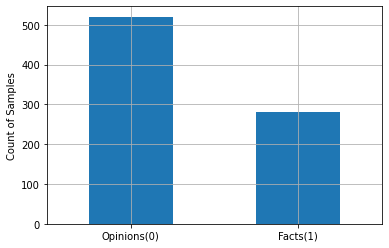

In [3]:
total_data['Label'].value_counts().plot(kind='bar')
plt.grid()
plt.xticks([0,1],["Opinions(0)","Facts(1)"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()

## **DATA PREPROCESSING**


In [4]:
def preproc(data):
  stopword=""
  cleantext = " "
  stopword = set(stopwords.words('english'))
  for i in word_tokenize(data):
    if(any(j.isdigit() for j in i)): ## checking if the word has any numerics...
      continue
    i=i.lower()
    if (i not in stopword) and (len(i)>2):
      pattern1 = '[!.?$\[\]/\}#=<>"\*:,|_~;()^\']'
      pattern2 = '[\n\n]+'
      pattern3 = '[\ \ ]+'
      wout_sc = re.sub(pattern1,'',i) #removing special characters
      wout_el = re.sub(pattern2,'\n',wout_sc) # removing empty lines (which are greater than 2)
      wout_mspaces = re.sub(pattern3,' ',wout_el) # removing multiple spaces
      cleaned_text = wout_mspaces.strip()
      cleaned_text=lemmatizer.lemmatize(cleaned_text)
      if (i not in stopword) and (len(i)>2):
        cleantext = cleantext+cleaned_text+" "
  return cleantext.strip()

In [5]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
for i in tqdm(range(len(total_data)),leave=True,position=0):
  total_data.iloc[i,0] = preproc(total_data.iloc[i,0])

100%|██████████| 801/801 [00:01<00:00, 405.44it/s]


## **PREPROCESSED DATA PICKLED**

In [7]:
pickle_out = open("./facts_opinions_ppdata2.csv","wb")
pickle.dump(total_data, pickle_out)

## **LOADING THE PREPROCESSED DATA**

In [8]:
pickle_in = open("./facts_opinions_ppdata2.csv","rb")
total_data = pickle.load(pickle_in)

## **DATA AFTER PRE-PROCESSING**

In [9]:
total_data.head()

,Text,Label
0,want find way end racism try force people inje...,0
1,child almost died tetanus spent month hospital...,1
2,remember mr leblanc pressure provincial busine...,0
3,would expect case rise significantly course va...,0
4,depends whether vaccination status embedded co...,0


## **SEPERATING OUT TEXT AND CORRESPONDING LABELS**

In [10]:
data_y = pd.DataFrame(data=total_data['Label'],columns=['Label'])
data_x = total_data.drop(columns="Label")

In [11]:
data_y.columns,data_x.columns

(Index(['Label'], dtype='object'), Index(['Text'], dtype='object'))

## **PERFORMING TRAIN-CV-TEST SPLITS**

In [12]:
x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,train_size=0.7,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,train_size=0.7,random_state=42)
print("Shape of X_Train::",x_train.shape)
print("Shape of X_Cv::",x_cv.shape)
print("Shape of X_Test::",x_test.shape)
print("Shape of Y_Train::",y_train.shape)
print("Shape of Y_Cv::",y_cv.shape)
print("Shape of Y_Test::",y_test.shape)

Shape of X_Train:: (392, 1)
Shape of X_Cv:: (168, 1)
Shape of X_Test:: (241, 1)
Shape of Y_Train:: (392, 1)
Shape of Y_Cv:: (168, 1)
Shape of Y_Test:: (241, 1)


## **WRITING TEST DATA INTO CSV FOR VERIFICATION DURING DEPLOYMENT**

In [13]:
x_test.to_csv("./x_test2.csv",index=False)
y_test.to_csv("./y_test2.csv",index=False)

## **CLASS-WISE COUNT OF SAMPLES IN TRAINING DATA**

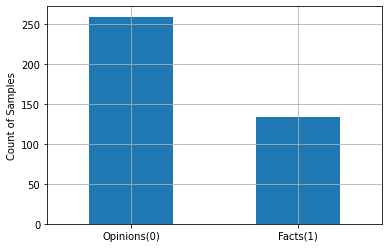

In [14]:
y_train['Label'].value_counts().plot(kind='bar')
plt.grid()
plt.xticks([0,1],["Opinions(0)","Facts(1)"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()
plt.show()

## **CLASS-WISE COUNT OF SAMPLES IN CV DATA**

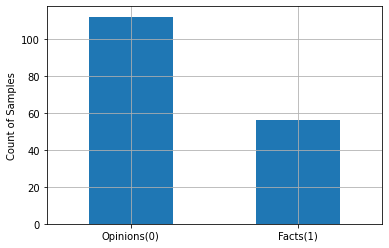

In [15]:
y_cv['Label'].value_counts().plot(kind='bar')
plt.grid()
plt.xticks([0,1],["Opinions(0)","Facts(1)"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()
plt.show()

## **CLASS-WISE COUNT OF SAMPLES IN TEST DATA**

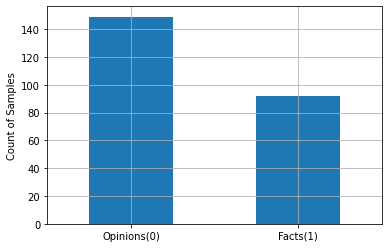

In [16]:
y_test['Label'].value_counts().plot(kind='bar')
plt.grid()
plt.xticks([0,1],["Opinions(0)","Facts(1)"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()
plt.show()

## **MAXIMUM LENGTH OF THE TEXT IN TRAINING DATA**

In [17]:
max_len=0
l=[]
index=[]
for i in range(len(x_train)):
  cur_len = len(x_train.iloc[i,0].split())
  if(cur_len>max_len):
    max_len=cur_len
print("Maximum length of sentence::",max_len)

Maximum length of sentence:: 35


## **GENEARTING VOCABULARY FROM TRAINING DATA**

In [18]:
vocab={}
for i in tqdm(x_train['Text'],position=0,leave=True):
  for j in i.split():
    if j not in vocab:
      vocab[j]=1
    else:
      vocab[j]+=1
vocab = sorted(vocab, key=vocab.get, reverse=True)

100%|██████████| 392/392 [00:00<00:00, 268742.59it/s]


## **VECTORIZING THE DATA**

In [19]:
def vectorize(data,vocab):
  print("\nGenerating Vectors......")
  max_seq_len=1400
  row=0
  ## converting sequence to vector...
  new_data = pd.DataFrame(columns=["Text"])
  for i in tqdm(data['Text'],position=0,leave=True):
    sent=[]
    for j in i.split():
      try:
        sent.append((vocab.index(j))+1)
      except:
        continue
    new_data.loc[row] = [sent]
    row+=1
  new_data = sequence.pad_sequences(new_data['Text'], maxlen=max_seq_len)
  return new_data ## if its CV/TEST data we return the numerical vectors computed w.r.t training vocab

In [20]:
x_train_vec = vectorize(x_train,vocab)
x_cv_vec = vectorize(x_cv,vocab)
x_test_vec = vectorize(x_test,vocab)


Generating Vectors......


100%|██████████| 392/392 [00:00<00:00, 1106.63it/s]



Generating Vectors......


100%|██████████| 168/168 [00:00<00:00, 1054.26it/s]



Generating Vectors......


100%|██████████| 241/241 [00:00<00:00, 1042.29it/s]


## **THE LSTM ARCHITECTURE**

In [21]:
from keras.utils import np_utils
from tensorflow.keras import models
import tensorflow as tf
lstm_model = Sequential()
lstm_model.add(Embedding(1+len(vocab),20,input_length=1400)) #taking whole length of vocab
lstm_model.add(LSTM(20))
lstm_model.add(Dense(2, activation='softmax'))
checkpoint = ModelCheckpoint('./saved models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  
lstm_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['acc'])
values=lstm_model.fit(x_train_vec,keras.utils.np_utils.to_categorical(y_train,num_classes=2),epochs=20,batch_size=1000,validation_data=(x_cv_vec,keras.utils.np_utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint])

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.6933 - acc: 0.4872 - val_loss: 0.6828 - val_acc: 0.6667

Epoch 00001: val_loss improved from inf to 0.68276, saving model to ./saved models\model-001-0.487245-0.666667.h5
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 0.6787 - acc: 0.6607 - val_loss: 0.6671 - val_acc: 0.6667

Epoch 00002: val_loss improved from 0.68276 to 0.66714, saving model to ./saved models\model-002-0.660714-0.666667.h5
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 0.6556 - acc: 0.6607 - val_loss: 0.6437 - val_acc: 0.6667

Epoch 00003: val_loss improved from 0.66714 to 0.64373, saving model to ./saved models\model-003-0.660714-0.666667.h5
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 0.6175 - acc: 0.6607 - val_loss: 0.6337 - val_acc: 0.6667

Epoch 00004: val_loss improved from 0.64373 to 0.63374, saving model to ./saved models\model-004-0.660714-0.666667.h5
Epoch 5/20
1/1 [====

In [27]:
# pip install tensorflow --upgrade --force-reinstall

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached setuptools-60.9.3-py3-none-any.whl (1.1 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\rachel\\anaconda3\\envs\\tf\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached typing_extensions-4.1.1-py3-none-any.whl (26 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached libclang-13.0.0-py2.py3-none-win_amd64.whl (13.9 MB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached google_auth-2.6.0-py2.py3-none-any.whl (156 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.0.3-py3-none-any.whl (289 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using 

## **EPOCHS V/S LOSS**

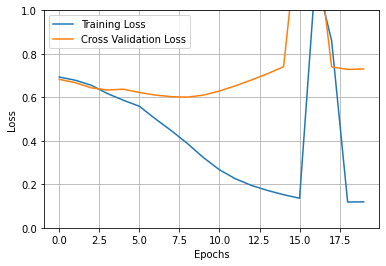

In [22]:
plt.plot(values.history['loss'],label = "Training Loss")
plt.plot(values.history['val_loss'],label = "Cross Validation Loss")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

## **EPOCHS V/S ACCURACY**

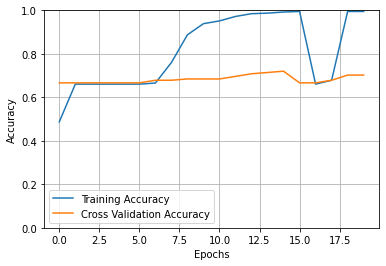

In [23]:
plt.plot(values.history['acc'],label = "Training Accuracy")
plt.plot(values.history['val_acc'],label = "Cross Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## **PERFORMANCE ON TEST DATA**

#### **CONFUSION MATRIX ON TEST DATA**

In [24]:
from sklearn.metrics import confusion_matrix
from IPython.display import display
classes=["Opinions","Facts"]
y_pred = np.argmax(lstm_model.predict(x_test_vec), axis=-1)
# y_pred = lstm_model.predict(x_test_vec)
conf_df = pd.DataFrame(confusion_matrix(y_test,y_pred),columns=classes,index=classes)
conf_df.index.name = 'True labels'
display(conf_df)

,Opinions,Facts
True labels,,
Opinions,103,46
Facts,31,61


#### **ACCURACY ON TEST DATA**

In [25]:
numer = conf_df.iloc[0,0]+conf_df.iloc[1,1]
denom = conf_df.iloc[0,0]+conf_df.iloc[0,1]+conf_df.iloc[1,0]+conf_df.iloc[1,1]
print("Accuracy on Test Data::",100*numer/denom)

Accuracy on Test Data:: 68.04979253112033


## **VOCABULARY WRITTEN TO A PICKLE FILE**

In [0]:
#pickle_out = open("/content/drive/My Drive/IR_PROJECT/vocab","wb")
#pickle.dump(vocab, pickle_out)

In [0]:
pickle_in = open("/content/drive/My Drive/IR_PROJECT/vocab","rb")
vocab2 = pickle.load(pickle_in)

## **SAVING THE MODEL**

In [0]:
#pickle_out = open("/content/drive/My Drive/IR_PROJECT/saved models/LSTM_model_2","wb")
#pickle.dump(lstm_model, pickle_out)

In [0]:
pickle_in = open("/content/drive/My Drive/IR_PROJECT/saved models/LSTM_model_2","rb")
lstmtest = pickle.load(pickle_in)